In [1]:
from typing import List, Tuple
import pickle as pic

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
import log_parser

In [3]:
KEYROUND_WIDTH_4 = 60
KEYROUND_WIDTH_B4 = 98

KEY_WIDTH_4 = 256
KEY_WIDTH_B4 = 512

BLOCK_WIDTH_4 = 5
BLOCK_WIDTH_B4 = 7

In [4]:
HW = [bin(n).count("1") for n in range(0, 256)]

In [5]:
def corr_coef(hypotheses, traces):
    #Initialize arrays & variables to zero
    num_traces, num_points = traces.shape
    sumnum = np.zeros(num_points)
    sumden1 = np.zeros(num_points)
    sumden2 = np.zeros(num_points)

    #Mean of hypotheses
    h_mean = np.mean(hypotheses, dtype=np.float64)

    #Mean of all points in trace
    t_mean = np.mean(traces, axis=0, dtype=np.float64)

    #For each trace, do the following
    for t_idx in range(num_traces):
        h_diff = (hypotheses[t_idx] - h_mean)
        t_diff = traces[t_idx, :] - t_mean

        sumnum = sumnum + (h_diff * t_diff)
        sumden1 = sumden1 + h_diff * h_diff 
        sumden2 = sumden2 + t_diff * t_diff

    correlation = sumnum / np.sqrt(sumden1 * sumden2)

    return correlation

# Elisabeth-b4 - Filter block

## Attacking S-box S1

In [99]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-1-FilterBlock\\carto_eB4-Rnd-1-FilterBlock.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-1-FilterBlock\\carto_eB4-Rnd-1-FilterBlock.log"

In [100]:
traces_dict = sio.loadmat(traces_path)

traces = np.empty((len([k for k in traces_dict.keys() if 'data' in k]), 60000))
for i, k in enumerate([k for k in traces_dict.keys() if 'data' in k]):
    traces[i] = traces_dict[k][0, 0][4][:, 0]

num_traces = np.shape(traces)[0]
num_points = np.shape(traces)[1]

In [101]:
real_keys = log_parser.parse(key_path)

real_keys = np.array([key[0][0] for key in real_keys])

### Check our data

In [106]:
NR_PLOT = 5

C:\Users\ppace\AppData\Local\Temp\ipykernel_12796\3963726462.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


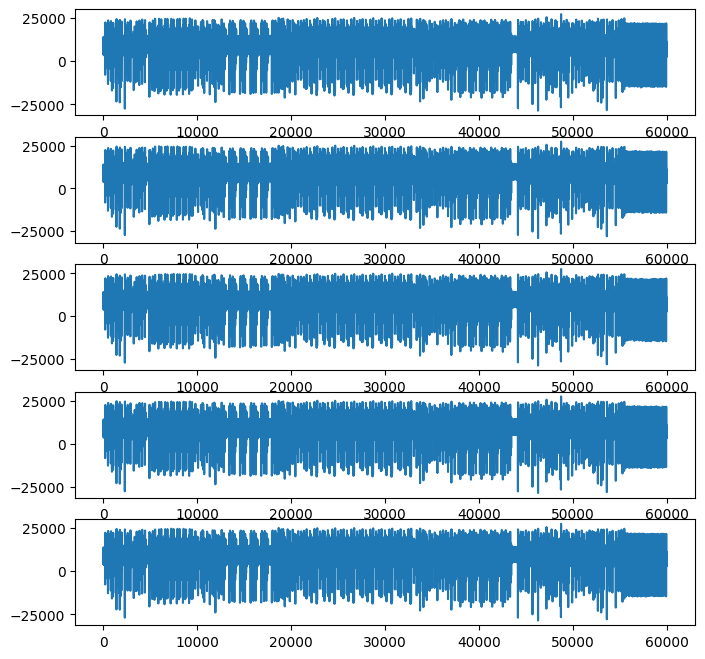

In [107]:
fig, axs = plt.subplots(NR_PLOT, figsize=(8, 8))
for ax, trace in zip(axs, traces[:NR_PLOT]):
    ax.plot(trace)
fig.show()

### Find the timepoint where S1 is executed

In [12]:
s1 = [0x09, 0x01, 0x05, 0x05, 0x00, 0x0C, 0x02, 0x06, 0x07, 0x0F, 0x0B, 0x0B, 0x10, 0x04, 0x0E, 0x0A]

def hypothesis_s1(x1: int, x2: int) -> int:
    return HW[s1[(x1 + x2) % 16]]


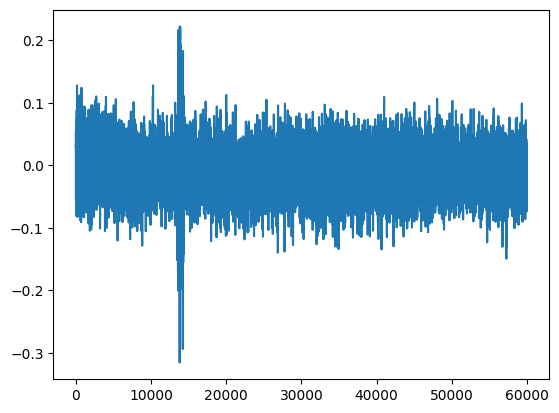

In [13]:
plt.plot(corr_coef([hypothesis_s1(int(key[1], 16), int(key[2], 16)) for key in real_keys], traces))

Wow !!!

(13500.0, 14500.0)

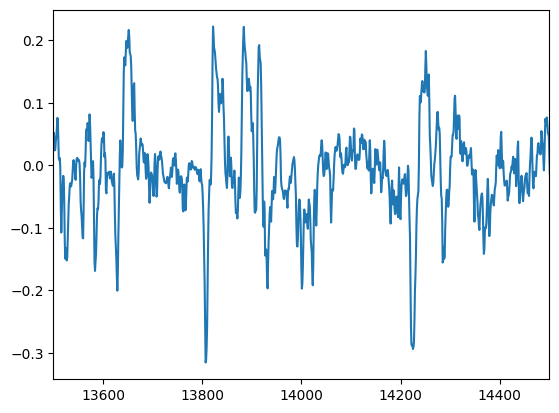

In [14]:
plt.plot(corr_coef([hypothesis_s1(int(key[1], 16), int(key[2], 16)) for key in real_keys], traces))
plt.xlim([13500, 14500])

## Attacking the filter S-boxes

### Finding their locations in time

In [6]:
s_boxes_b4 = [
    [0x0A, 0x06, 0x0B, 0x08, 0x04, 0x09, 0x08, 0x0C, 0x06, 0x0A, 0x05, 0x08, 0x0C, 0x07, 0x08, 0x04],
    [0x09, 0x01, 0x05, 0x05, 0x00, 0x0C, 0x02, 0x06, 0x07, 0x0F, 0x0B, 0x0B, 0x10, 0x04, 0x0E, 0x0A],
    [0x0D, 0x0E, 0x0E, 0x02, 0x03, 0x09, 0x03, 0x05, 0x03, 0x02, 0x02, 0x0E, 0x0D, 0x07, 0x0D, 0x0B],
    [0x02, 0x09, 0x08, 0x0B, 0x0D, 0x08, 0x01, 0x07, 0x0E, 0x07, 0x08, 0x05, 0x03, 0x08, 0x0F, 0x09],
    [0x0B, 0x03, 0x0F, 0x09, 0x00, 0x00, 0x0C, 0x00, 0x05, 0x0D, 0x01, 0x07, 0x10, 0x10, 0x04, 0x10],
    [0x0F, 0x0C, 0x01, 0x0F, 0x0E, 0x01, 0x06, 0x0C, 0x01, 0x04, 0x0F, 0x01, 0x02, 0x0F, 0x0A, 0x04],
    [0x06, 0x0E, 0x0D, 0x00, 0x07, 0x0E, 0x0C, 0x03, 0x0A, 0x02, 0x03, 0x10, 0x09, 0x02, 0x04, 0x0D],
    [0x0C, 0x00, 0x04, 0x01, 0x0F, 0x0B, 0x04, 0x00, 0x04, 0x10, 0x0C, 0x0F, 0x01, 0x05, 0x0C, 0x10],
    [0x0B, 0x00, 0x0F, 0x0A, 0x09, 0x0B, 0x09, 0x02, 0x05, 0x10, 0x01, 0x06, 0x07, 0x05, 0x07, 0x0E],
    [0x0D, 0x03, 0x0B, 0x0B, 0x08, 0x09, 0x08, 0x0C, 0x03, 0x0D, 0x05, 0x05, 0x08, 0x07, 0x08, 0x04],
    [0x0A, 0x02, 0x08, 0x04, 0x0F, 0x0B, 0x06, 0x04, 0x06, 0x0E, 0x08, 0x0C, 0x01, 0x05, 0x0A, 0x0C],
    [0x0D, 0x08, 0x0E, 0x08, 0x02, 0x05, 0x03, 0x0B, 0x03, 0x08, 0x02, 0x08, 0x0E, 0x0B, 0x0D, 0x05],
    [0x0D, 0x0F, 0x02, 0x05, 0x05, 0x0F, 0x09, 0x0B, 0x03, 0x01, 0x0E, 0x0B, 0x0B, 0x01, 0x07, 0x05],
    [0x0D, 0x00, 0x0A, 0x0A, 0x06, 0x07, 0x03, 0x0E, 0x03, 0x10, 0x06, 0x06, 0x0A, 0x09, 0x0D, 0x02],
    [0x00, 0x04, 0x07, 0x00, 0x09, 0x04, 0x0C, 0x00, 0x10, 0x0C, 0x09, 0x10, 0x07, 0x0C, 0x04, 0x10],
    [0x04, 0x0B, 0x06, 0x03, 0x0F, 0x06, 0x0C, 0x02, 0x0C, 0x05, 0x0A, 0x0D, 0x01, 0x0A, 0x04, 0x0E],
    [0x03, 0x0C, 0x01, 0x08, 0x08, 0x0F, 0x0D, 0x0F, 0x0D, 0x04, 0x0F, 0x08, 0x08, 0x01, 0x03, 0x01],
    [0x0B, 0x03, 0x02, 0x0C, 0x03, 0x08, 0x04, 0x02, 0x05, 0x0D, 0x0E, 0x04, 0x0D, 0x08, 0x0C, 0x0E]
]

In [7]:
from ctypes import *

class aes_ctx(Structure):
    _fields_ = [
        ("RoundKey", c_uint8 * 176),
        ("Iv", c_uint8 * 16)
    ]

class ecrypt_ctx(Structure):
    _fields_ = [
        ("input", c_uint32 * 16)
    ]

class rng(Structure):
    pass

rng._fields_ = [
    ("indices", c_uint16 * 512),
    ("whitening", c_uint8 * 98),
    ("mode", c_int),
    ("gen_rand_uniform", CFUNCTYPE(c_uint8, POINTER(rng), POINTER(c_uint8))),
    ("copy", CFUNCTYPE(None, POINTER(rng), POINTER(rng))),
    ("next_elem", CFUNCTYPE(None, POINTER(rng)))
]

class rng_aes(Structure):
    _fields_ = [
        ("r", rng),
        ("ctx", aes_ctx),
        ("ctr", c_uint8 * 16),
        ("batch_idx", c_size_t)
    ]

class rng_cha(Structure):
    _fields_ = [
        ("r", rng),
        ("ctx", ecrypt_ctx),
        ("batch_idx", c_size_t)
    ]

lib = CDLL("./py_gen_rng.so")

def aes_random_4(seed: str):
    r = rng_aes()
    lib.rng_new_aes(byref(r), int(seed, 16).to_bytes(length=16, byteorder="little"), 1)
    return list(r.r.indices), list(r.r.whitening)
    
def aes_random_b4(seed: str):
    r = rng_aes()
    lib.rng_new_aes(byref(r), int(seed, 16).to_bytes(length=16, byteorder="little"), 0)
    return list(r.r.indices), list(r.r.whitening)
    
def chacha_random_4(seed: str):
    r = rng_cha()
    lib.rng_new_cha(byref(r), int(seed, 16).to_bytes(length=16, byteorder="little"), 1)
    return list(r.r.indices), list(r.r.whitening)
    
def chacha_random_b4(seed: str):
    r = rng_cha()
    lib.rng_new_cha(byref(r), int(seed, 16).to_bytes(length=16, byteorder="little"), 0)
    return list(r.r.indices), list(r.r.whitening)

In [8]:
def hypothesis_b4_rws_sboxes_location(iv: str, key: List[int], round_idx: int, block_idx: int) -> int:
    indices, whitening = chacha_random_b4(iv)

    block = [(key[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

    if block_idx != BLOCK_WIDTH_B4 - 1:
        if block_idx % 2 == 0:
            sbox_out = s_boxes_b4[block_idx][block[block_idx]]
        else:
            sbox_out = s_boxes_b4[block_idx][(block[block_idx] + block[block_idx - 1]) % 16]
        return HW[sbox_out]
    else:
        for i in range(3):
            block[2*i + 1] = (block[2*i + 1] + block[2*i]) % 16
        y = [s_boxes_b4[i][block[i]] for i in range(BLOCK_WIDTH_B4 - 1)]
        z = [(y[(2*i + 5*j - 1) % (BLOCK_WIDTH_B4 - 1)] + y[2*i + j]) % 16 for i in range(3) for j in range(2)]
        z = [s_boxes_b4[6 + i][(z[i] + block[(i + 2) % (BLOCK_WIDTH_B4 - 1)]) % 16] for i in range(BLOCK_WIDTH_B4 - 1)]
        t_0 = (z[0] + z[1] + z[2]) % 16
        t_0 = (t_0 + block[block_idx - 1]) % 16
        sbox_out = s_boxes_b4[12][t_0]

        return HW[(block[block_idx] + sbox_out) % 16]

In [9]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"

In [10]:
traces_dict = sio.loadmat(traces_path, variable_names=[f"data_{i}" for i in range(1, 50002)])
traces = np.stack([traces_dict[f"data_{i}"][0, 0][4][:, 0] for i in range(1, len(traces_dict) - 2) if i != 39337], axis=0)
del traces_dict
traces = traces.reshape((1, -1, traces.shape[1]))
traces.shape

(1, 50000, 50002)

In [11]:
inputs_outputs = log_parser.parse(key_path)
real_keys = np.array([inputs_outputs[1][0][0]])
real_keys = np.array([[int(c, 16) for c in key] for key in real_keys])

seeds = np.array([inputs_outputs[2*i][0][0] for i in range(0, 50001) if i != 39336])
seeds = seeds.reshape((-1, traces.shape[1]))

In [12]:
assert traces.shape[0] == seeds.shape[0]

In [81]:
corrrelation_0_0 = corr_coef(np.array([hypothesis_b4_rws_sboxes_location(iv, key, 0, 0) for i, key in enumerate(real_keys[:1]) for iv in seeds[i][:500]]), traces.reshape((-1, POINTS_PER_SAMPLE))[:500])

In [35]:
with open("correlation_locations_b4_1000.pic", "rb") as r:
    correlation_locations = pic.load(r)

In [28]:
correlation_locations = [[[0] * 10] * BLOCK_WIDTH_B4] * (KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2)

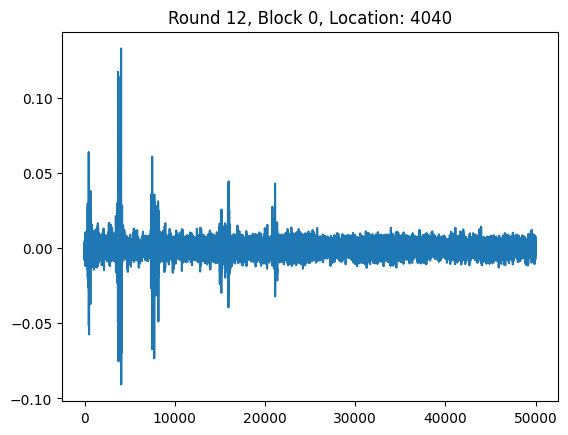

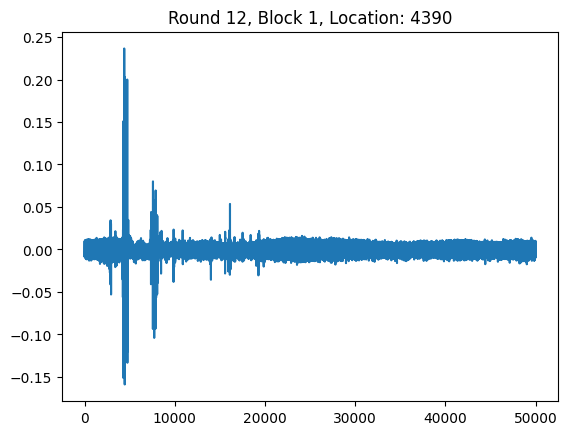

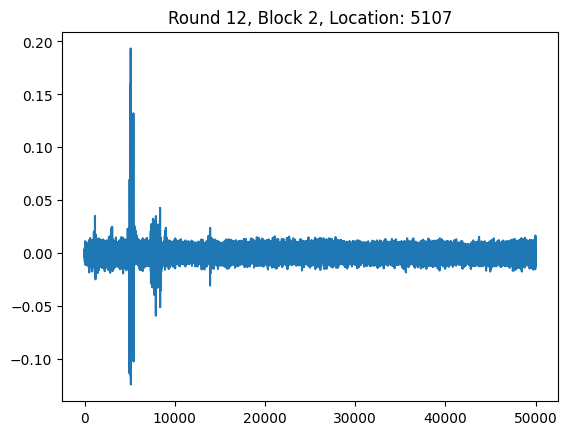

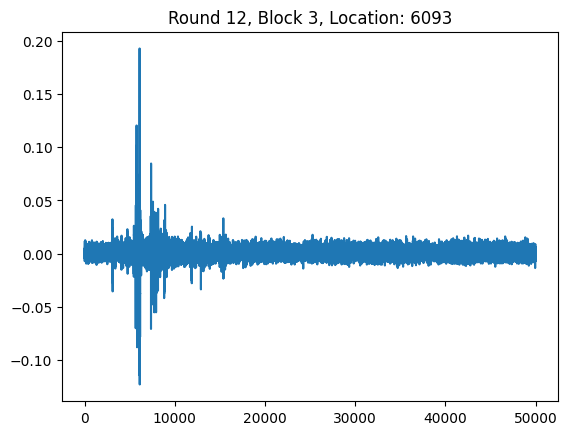

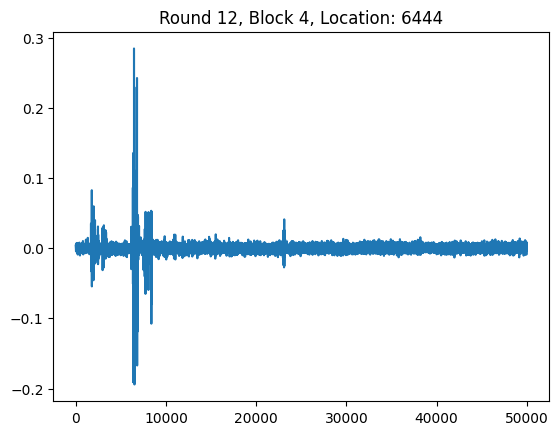

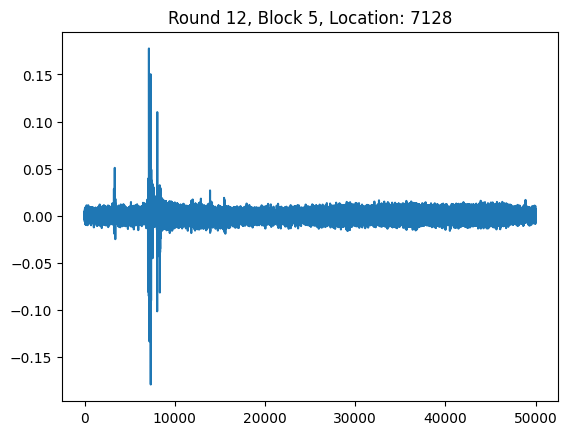

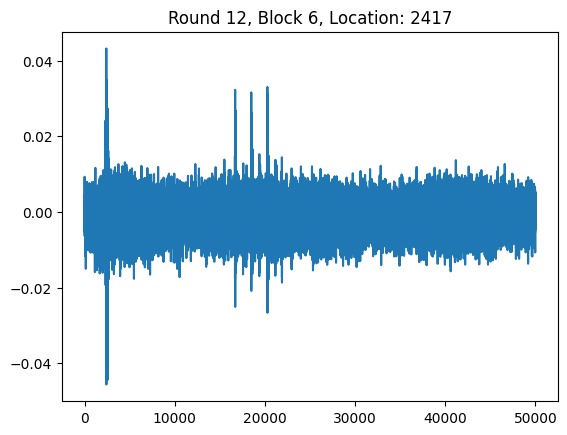

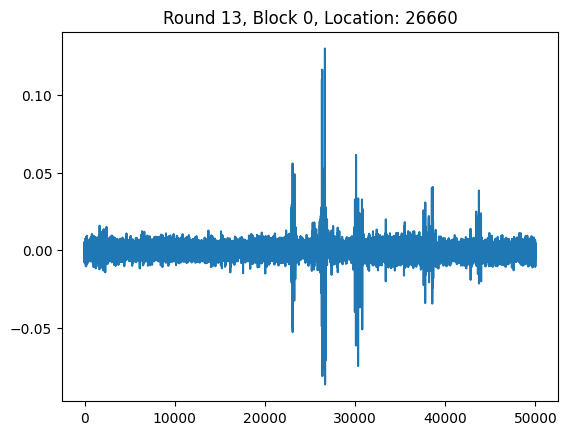

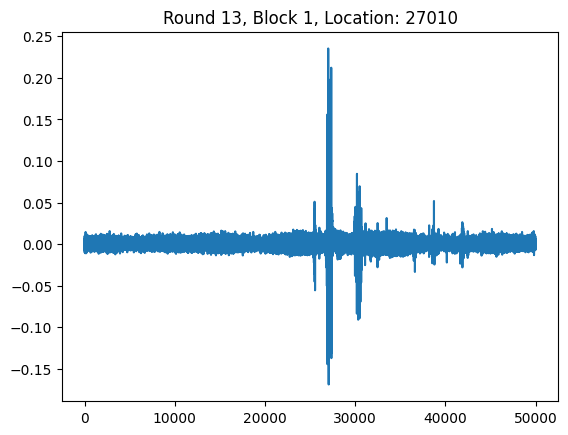

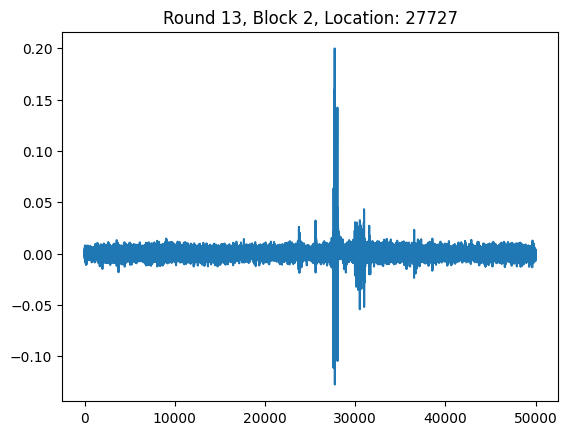

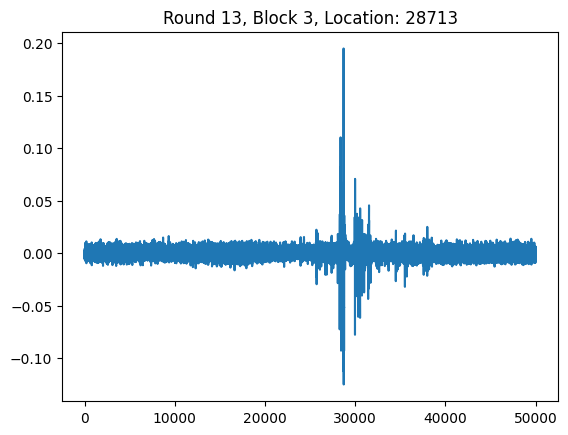

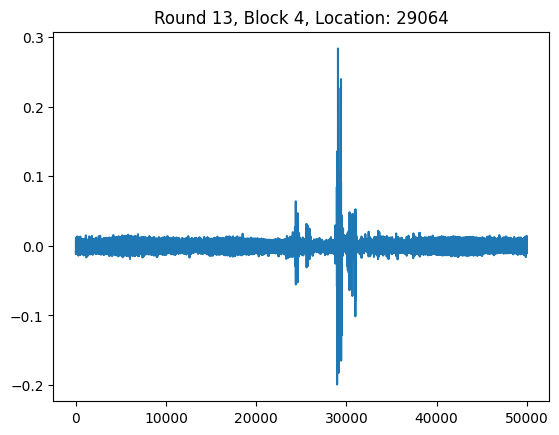

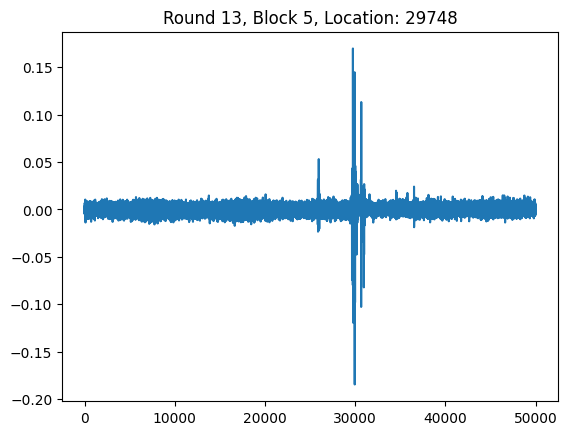

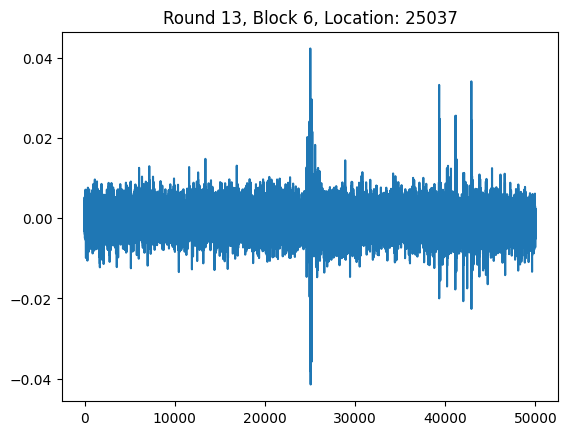

In [31]:
for round_idx in range(len(correlation_locations), KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
    corr_round = []
    for block_idx in range(BLOCK_WIDTH_B4):
        hyps = np.array([hypothesis_b4_rws_sboxes_location(iv, key, round_idx, block_idx) for i, key in enumerate(real_keys) for iv in seeds[i]])
        corr = corr_coef(hyps, traces.reshape((-1, traces.shape[2])))
        loc = np.argmax(corr)
        corr_round.append(list(range(loc - 5, loc + 5)))
        plt.plot(corr)
        plt.title(f"Round {round_idx}, Block {block_idx}, Location: {loc}")
        plt.show()
    correlation_locations.append(corr_round)
correlation_locations = np.array(correlation_locations)

In [50]:
with open("correlation_locations_b4_two_last_rounds.pic", "wb") as w:
    pic.dump(correlation_locations, w)

In [36]:
with open("correlation_locations_b4_1000.pic", "wb") as w:
    pic.dump(correlation_locations, w)

In [77]:
def indices_locations_and_hyps_to_use_for_key_nibble(key_guess: List[int], key_target_idx: int, total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    seeds_indices = np.zeros_like(total_seeds, dtype=bool)
    location_mask_per_trace = np.zeros_like(total_traces, dtype=bool)
    hypotheses = np.zeros_like(total_seeds, dtype=int)

    for i, iv in enumerate(total_seeds):
        indices, whitening = chacha_random_b4(iv)
        keyround_target_idx = indices.index(key_target_idx)
        if keyround_target_idx < KEYROUND_WIDTH_B4:
            round_idx = keyround_target_idx // BLOCK_WIDTH_B4
            block_idx = keyround_target_idx % BLOCK_WIDTH_B4
            locs = locations[round_idx][block_idx]

            # For now, we only attack even-indexed keyrounds (but not the last one) because they depend on a single key nibble
            # TO REMOVE IF BETTER IDEA IS FOUND
            #if block_idx == BLOCK_WIDTH_B4 - 1 or block_idx % 2 != 0:
            if round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 or block_idx != 4:
            #if (round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 and round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2) or block_idx != 0:
                continue
            # TO REMOVE IF BETTER IDEA IS FOUND

            seeds_indices[i] = True
            location_mask_per_trace[i][locs] = True

            block = [(key_guess[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

            if block_idx != BLOCK_WIDTH_B4 - 1:
                if block_idx % 2 == 0:
                    sbox_out = s_boxes_b4[block_idx][block[block_idx]]
                else:
                    raise ValueError("Should not happen")
                    sbox_out = s_boxes_b4[block_idx][(block[block_idx] + block[block_idx - 1]) % 16]
                hypotheses[i] = HW[sbox_out]
            else:
                raise ValueError("Should not happen")
                for i in range(3):
                    block[2*i + 1] = (block[2*i + 1] + block[2*i]) % 16
                y = [s_boxes_b4[i][block[i]] for i in range(BLOCK_WIDTH_B4 - 1)]
                z = [(y[(2*i + 5*j - 1) % (BLOCK_WIDTH_B4 - 1)] + y[2*i + j]) % 16 for i in range(3) for j in range(2)]
                z = [s_boxes_b4[6 + i][(z[i] + block[(i + 2) % (BLOCK_WIDTH_B4 - 1)]) % 16] for i in range(BLOCK_WIDTH_B4 - 1)]
                t_0 = (z[0] + z[1] + z[2]) % 16
                t_0 = (t_0 + block[block_idx - 1]) % 16
                sbox_out = s_boxes_b4[12][t_0]

                hypotheses[i] = HW[(block[block_idx] + sbox_out) % 16]

    return seeds_indices, location_mask_per_trace, hypotheses[seeds_indices]

Key 0: 

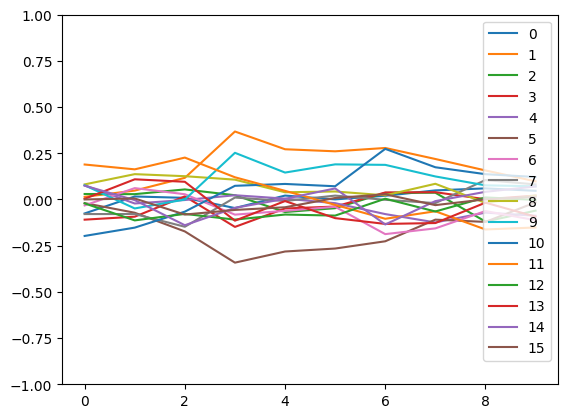

1[ 0.06008923  0.36782539  0.05440651  0.0394558   0.07666543 -0.01556469
  0.06147276  0.10517455  0.13707987  0.2524888   0.27384657  0.22667789
  0.01113339  0.10915382  0.07461354  0.02798972]


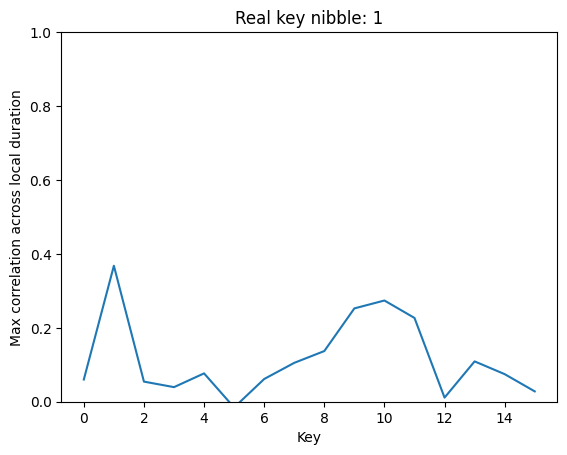

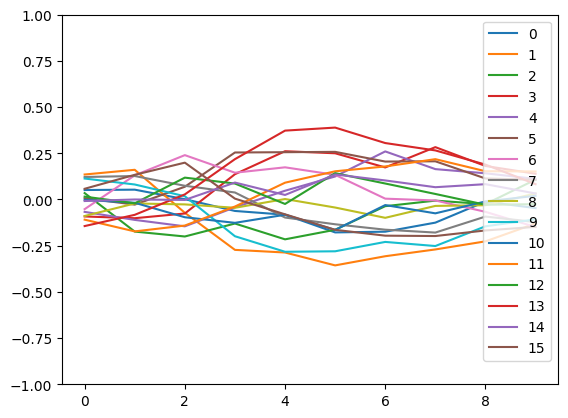

D[0.0531361  0.16062962 0.10742625 0.28321245 0.26005882 0.25769259
 0.23995885 0.12689976 0.03249567 0.11336084 0.01988461 0.21817181
 0.14238006 0.38897066 0.13536575 0.19926547]


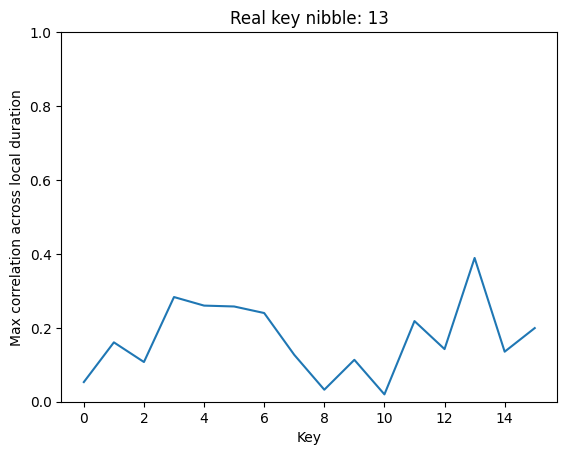

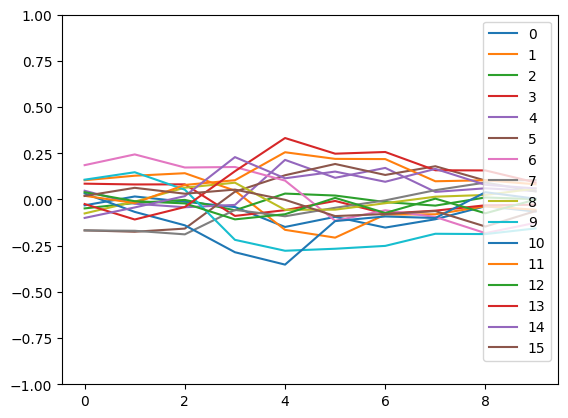

D[0.0162649  0.14216953 0.03188495 0.08556649 0.21425649 0.19205538
 0.24382709 0.09153172 0.09079563 0.14740672 0.03924671 0.25558069
 0.03915297 0.33255981 0.22927882 0.06303766]


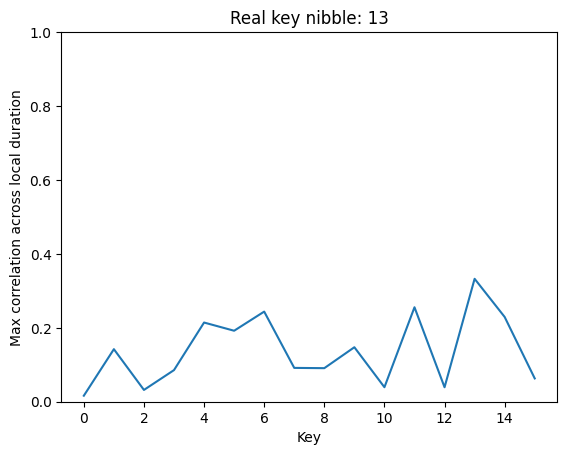

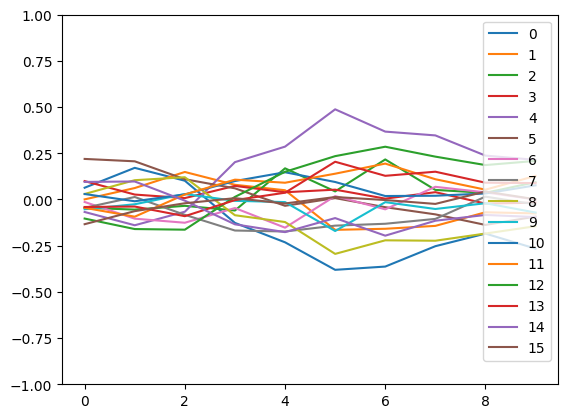

4[0.17114577 0.14887225 0.21667961 0.09941917 0.48784751 0.21944673
 0.06852131 0.01532019 0.12038698 0.02926323 0.14736736 0.19415425
 0.28547319 0.20415142 0.0973719  0.04293796]


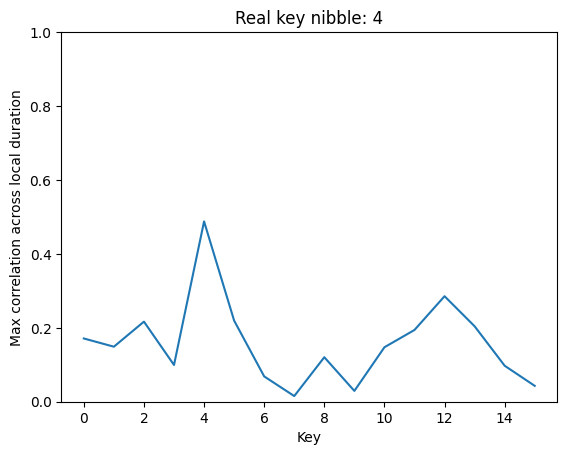

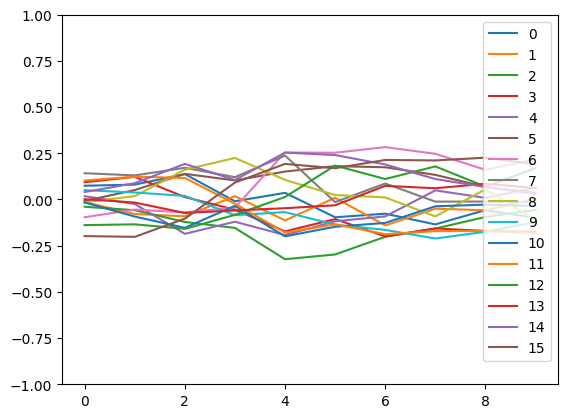

6[ 0.13741284  0.01819559 -0.03923328  0.1223656   0.0640647   0.1805092
  0.28331654  0.23742894  0.22464533  0.05029903 -0.01603     0.12341659
  0.18361733  0.08517365  0.25394771  0.22609069]


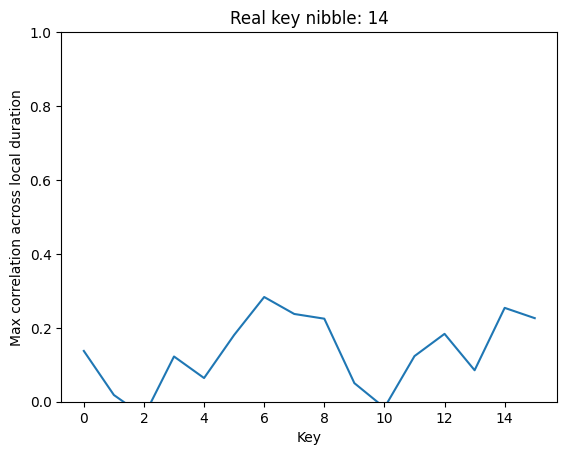

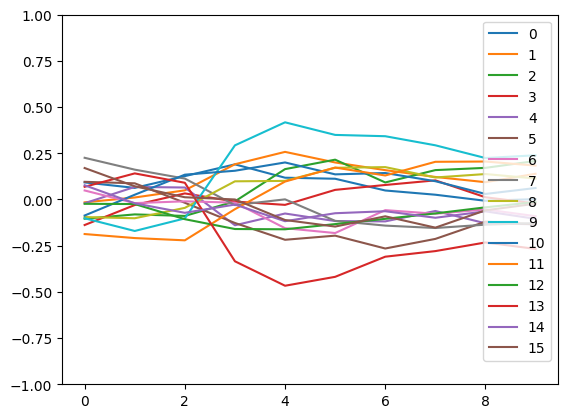

9[ 0.19009331  0.25756467  0.21540344  0.10346968  0.06787683  0.09549779
  0.04873785  0.22553535  0.17509863  0.41752974  0.20032078  0.20539265
 -0.01393747  0.14113622  0.07689091  0.17018428]


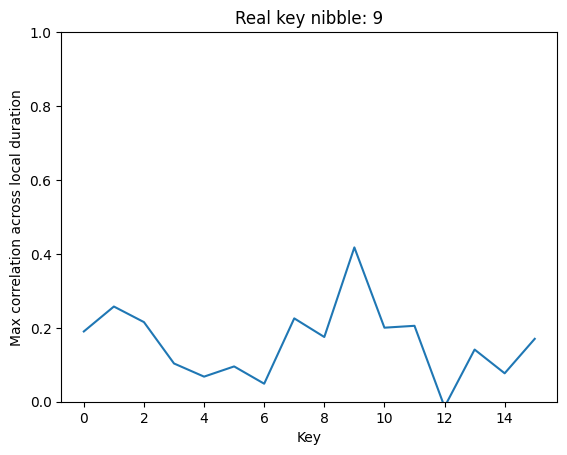

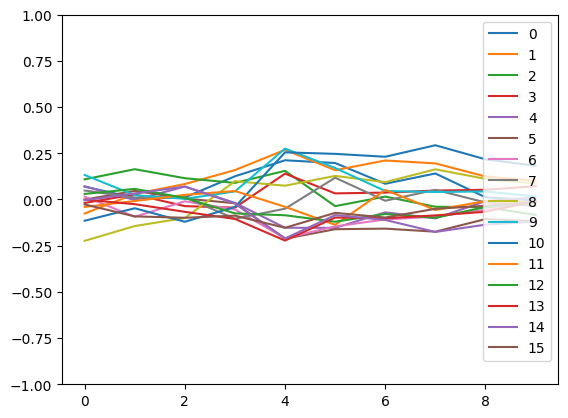

A[ 0.21215139  0.26857356  0.16382232  0.1397791   0.07100346  0.04647561
  0.01564747  0.11773166  0.16330483  0.27545405  0.29351405  0.05157017
  0.0572204  -0.00114722  0.06986231 -0.01523849]


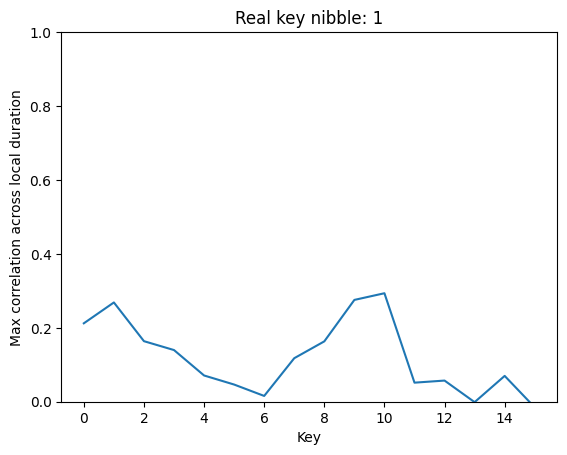

4

KeyboardInterrupt: 

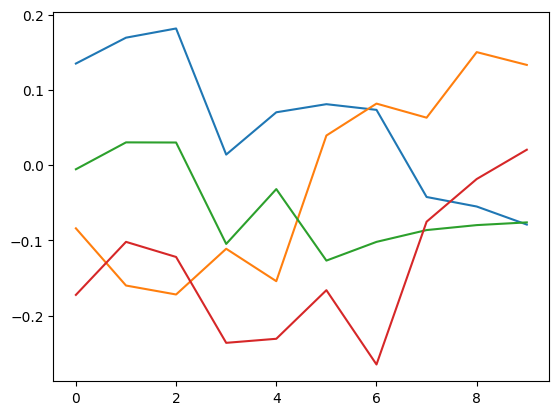

In [80]:
reconstructed_keys = np.zeros_like(real_keys)
for i in range(reconstructed_keys.shape[0]):
    print(f"Key {i}: ", end="")
    for j in range(reconstructed_keys.shape[1]):
        max_corrs = np.empty(16)

        for k in range(16):
            print(hex(k)[2:].upper(), end="")
            reconstructed_keys[i][j] = k

            indices, location_masks, hypotheses = indices_locations_and_hyps_to_use_for_key_nibble(reconstructed_keys[i], j, seeds[i], traces[i], correlation_locations)#np.array([[list(range(correlation_locations[i][j][5] - 25, correlation_locations[i][j][5] + 25)) for j in range(correlation_locations.shape[1])] for i in range(correlation_locations.shape[0])]))

            selected_seeds = seeds[i][indices]
            selected_traces = traces[i][location_masks].reshape((selected_seeds.shape[0], correlation_locations.shape[2]))

            corr = corr_coef(hypotheses, selected_traces)

            plt.plot(corr, label=str(k))

            #max_corrs[k] = np.max(np.abs(corr))
            max_corrs[k] = np.max(corr)
            print("\b", end="")

        plt.ylim([-1, 1])
        plt.legend()
        plt.show()

        best_k = np.argmax(max_corrs)
        reconstructed_keys[i][j] = best_k
        print(hex(best_k)[2:].upper(), end="")

        print(max_corrs)
        plt.plot(max_corrs)
        plt.xlabel("Key")
        plt.ylabel("Max correlation across local duration")
        plt.title(f"Real key nibble: {real_keys[i][j]}")
        plt.ylim([0, 1])
        plt.show()

    print()
    print(f"    vs {"".join([hex(k)[2:].upper() for k in real_keys[i]])}")
    print(f"{len(real_keys[i][real_keys[i] != reconstructed_keys[i]])} mistakes on {len(real_keys[i])} nibbles.")
    print()

In [ ]:
def hypothesis_b4_rws_one_key_nibble(iv: str, key: List[int], key_target_idx: int) -> Tuple[int, int, int]:
    indices, whitening = chacha_random_b4(iv)

    keyround_target_idx = indices.index(key_target_idx)
    if keyround_target_idx >= KEYROUND_WIDTH_B4:
        return -1

    block = [(key[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * (keyround_target_idx // BLOCK_WIDTH_B4), BLOCK_WIDTH_B4 * (keyround_target_idx // BLOCK_WIDTH_B4 + 1))]
    block_target_idx = keyround_target_idx % BLOCK_WIDTH_B4

    if block_target_idx != BLOCK_WIDTH_B4 - 1:
        if block_target_idx % 2 == 0:
            sbox_out = s_boxes_b4[block_target_idx][block[block_target_idx]]
        else:
            sbox_out = s_boxes_b4[block_target_idx][(block[block_target_idx] + block[block_target_idx - 1]) % 16]
        return HW[sbox_out], keyround_target_idx // BLOCK_WIDTH_B4, block_target_idx
    else:
        for i in range(3):
            block[2*i + 1] = (block[2*i + 1] + block[2*i]) % 16
        y = [s_boxes_b4[i][block[i]] for i in range(BLOCK_WIDTH_B4 - 1)]
        z = [(y[(2*i + 5*j - 1) % (BLOCK_WIDTH_B4 - 1)] + y[2*i + j]) % 16 for i in range(3) for j in range(2)]
        z = [s_boxes_b4[6 + i][(z[i] + block[(i + 2) % (BLOCK_WIDTH_B4 - 1)]) % 16] for i in range(BLOCK_WIDTH_B4 - 1)]
        t_0 = (z[0] + z[1] + z[2]) % 16
        t_0 = (t_0 + block[block_target_idx - 1]) % 16
        sbox_out = s_boxes_b4[12][t_0]

        return HW[(block[block_target_idx] + sbox_out) % 16], keyround_target_idx // BLOCK_WIDTH_B4, block_target_idx